<a href="https://colab.research.google.com/github/JacobDowns/CSCI-491-591/blob/main/lecture2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example: Doing Something Interesting with Numpy




In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
# Constants
A_PIPE = 0.6
G = 9.81
L_PIPE = 1
LX = 1
LY = 1
K_E = 0.003

In [4]:
from scipy.ndimage import gaussian_filter

def generate_terrain(n, steps=10):
  z = np.zeros((n, n))
  for i in range(steps):
    z_i = np.random.randn(n, n)
    sigma = float(n/(2.*(i+1)))
    z_i = gaussian_filter(z_i, sigma = sigma)
    z += z_i
  z = (z - z.min()) / (z.max() - z.min())
  return z



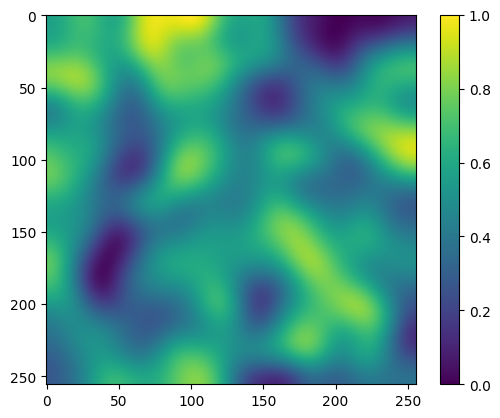

In [11]:
N = 256
z = 1.*generate_terrain(N)
plt.imshow(z)
plt.colorbar()
plt.show()

In [18]:
def update(z, h, r, fL, fR, fT, fB, dt, k_e=K_E):

    # Grid size
    N = z.shape[0]

    # 3.1 Water Increment
    # ========================================================================
    h1 = h + dt*r
    # Surface height = terrain + water
    H = z + h


    # 3.2.1 outflow flux computation
    # ================================================================
    # eqn 3
    # ----------------------------------------------------------------
    # difference in height between tile (j, i) and its neighbors.
    # this drives the initial flux calculations

    dhL = H[1:-1, 1:-1] - H[1:-1, 0:-2]
    dhR = H[1:-1, 1:-1] - H[1:-1, 2:]
    dhT = H[1:-1, 1:-1] - H[0:-2, 1:-1]
    dhB = H[1:-1, 1:-1] - H[2:, 1:-1]

    # eqn 2
    # ----------------------------------------------------------------
    # update flux from tile (j, i) to each neighbor.
    # we don't allow negative flux
    flux_factor = dt* A_PIPE / L_PIPE * G
    fL[1:-1, 1:-1] = np.maximum(flux_factor * dhL, 0)
    fR[1:-1, 1:-1] = np.maximum(flux_factor * dhR, 0)
    fT[1:-1, 1:-1] = np.maximum(flux_factor * dhT, 0)
    fB[1:-1, 1:-1] = np.maximum(flux_factor * dhB, 0)

    # eqn 4
    # ----------------------------------------------------------------
    # calculate adjustment factor.
    # this is to make sure that the outflow does not lead to a
    # negative water level in the tile.

    sum_f = fL + fR + fT + fB

    with np.errstate(divide='ignore', invalid='ignore'):
        factor = np.minimum(1.0, (h1 * LX * LY) / (sum_f * dt))
    factor = np.where(sum_f > 0.0, factor, 1.0)

    fL[1:-1, 1:-1] *= factor
    fR[1:-1, 1:-1] *= factor
    fT[1:-1, 1:-1] *= factor
    fB[1:-1, 1:-1] *= factor

    # Set edge fluxes to 0 to prevent leaking.
    fL[0, :] = 0
    fR[-1, :] = 0
    fT[:, 0] = 0
    fB[:, -1] = 0

    # 3.2.2 water surface and velocity field update
    # ================================================================

    # Flux coming into (j, i)
    sum_f_in = fR[1:-1,0:-2] + fT[2:, 1:-1] + fL[1:-1, 2:] + fB[0:-2, 1:-1]
    # Flux going out of (j, i)
    sum_f_out = fL[1:-1,1:-1] + fR[1:-1,1:-1] + fT[1:-1,1:-1] + fB[1:-1,1:-1]

    # eqn 6: delta volume
    # ----------------------------------------------------------------
    dvol = dt * (sum_f_in - sum_f_out)


    # eqn 7: update water height
    # ----------------------------------------------------------------
    dh = dvol / (LX * LY)
    h2 = h1[1:-1,1:-1] + dh

    # Overwrite h
    h[1:-1,1:-1] = np.maximum(0.0, h2[1:-1,1:-1] - k_e *dt)

    """
    h_mean = h1 + 0.5 * dh


    dwx = fR[1:-1, 0:-2] - fL[1:-1,1:-1] + fR[1:-1,1:-1] - fL[1:-1,2:]
    dwy = fB[0:-2, 1:-1] = fT[1:-1,1:-1] + fB[1:-1,1:-1] - fT[2:,1:-1]
    u[:,:] = 0.
    u[:,:] = 0.

    indexes = h_mean > 0.
    u[indexes] = dwx[indexes] / (LY * h_mean[indexes])
    v[indexes] = dwy[indexes] / (LX * h_mean[indexes])
    """

    return h, fL, fR, fB, fT


In [19]:
# Initial water height
h = np.zeros((N, N))
# Time step
dt = 0.1
# Fluxes
fL = np.zeros((N, N))
fR = np.zeros((N, N))
fT = np.zeros((N, N))
fB = np.zeros((N, N))

r = np.ones((N,N))*1e-3
steps = 100

for i in range(steps):
    print(i)
    update(z, h, r, fL, fR, fT, fB, dt)

    plt.subplot(2,1,1)
    plt.imshow(h)
    plt.colorbar()

    plt.subplot(2,1,2)
    plt.imshow(z)
    plt.colorbar()
    plt.show()






0


ValueError: operands could not be broadcast together with shapes (254,254) (256,256) 